$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

# How to Clone Qubits

Although it is impossible to build a qubit cloner that works on all states, it is perfectly possible to build a cloner that works on a pair of orthogonal states. You just perform a measurement that checks which of the two states was input to the cloner. If the result of the measurement is 0, you output the first of the two reference states. If the result is one, you swap the two reference qubits and output the second one.

In [5]:
import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor



### Dirac Notation

$(1,0,0,0) \rightarrow \ket{00}$

$(0,1,0,0) \rightarrow \ket{01}$

$(0,0,1,0) \rightarrow \ket{10}$

$(0,0,0,1) \rightarrow \ket{11}$

### Controlled-Not (CNOT)

<img src="CNOT.png" style="width:8in;"/>

| Dirac Notation | Vector Notation |
| ---------------------------- | --------------- |
|$\ket{00}\rightarrow\ket{00}$|$(1,0,0,0)\rightarrow(1,0,0,0)$|
|$\ket{01}\rightarrow\ket{01}$|$(0,1,0,0)\rightarrow(0,1,0,0)$|
|$\ket{10}\rightarrow\ket{11}$|$(0,0,1,0)\rightarrow(0,0,0,1)$|
|$\ket{11}\rightarrow\ket{10}$|$(0,0,0,1)\rightarrow(0,0,1,0)$|

Putting these vectors into the rows, the matrix for a CNOT gate is

$\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&0&1\\
0&0&1&0
\end{bmatrix}$

### Qubit-swapping Circuit

<img src="swapping-5.png" style="width:4in;"/>

| Dirac Notation | Vector Notation |
| ---------------------------- | --------------- |
|$\ket{xy}\rightarrow\ket{y\oplus x}\ket{x}$||
|$\ket{00}\rightarrow\ket{00}$|$(1,0,0,0)\rightarrow(1,0,0,0)$|
|$\ket{01}\rightarrow\ket{11}$|$(0,1,0,0)\rightarrow(0,0,0,1)$|
|$\ket{10}\rightarrow\ket{10}$|$(0,0,1,0)\rightarrow(0,0,1,0)$|
|$\ket{11}\rightarrow\ket{01}$|$(0,0,0,1)\rightarrow(0,1,0,0)$|

In [6]:
circuit = qiskit.QuantumCircuit(2,2)
circuit.cx(0,1)
circuit.cx(1,0)
circuit.cx(0,1)
circuit.measure(0,0)
circuit.draw()

┌───┐     ┌─┐
q_0: ──■──┤ X ├──■──┤M├
     ┌─┴─┐└─┬─┘┌─┴─┐└╥┘
q_1: ┤ X ├──■──┤ X ├─╫─
     └───┘     └───┘ ║ 
c: 2/════════════════╩═
                     0


Three CNOTs in series:

$\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&0&1\\
0&0&1&0\end{bmatrix}
\begin{bmatrix}
1&0&0&0\\
0&0&0&1\\
0&0&1&0\\
0&1&0&0
\end{bmatrix}\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&0&1\\
0&0&1&0
\end{bmatrix}=
\begin{bmatrix}
1&0&0&0\\
0&0&1&0\\
0&1&0&0\\
0&0&0&1\end{bmatrix}$

Verifying the circuit, reading off the columns:

| Vector Notation | Dirac Notation |
| --------------- | -------------- |
||$\ket{ab}\rightarrow\ket{ba}$|
| $(1,0,0,0)\rightarrow(1,0,0,0)$|$\ket{00}\rightarrow\ket{00}$|
| $(0,1,0,0)\rightarrow(0,0,1,0)$|$\ket{01}\rightarrow\ket{10}$|
| $(0,0,1,0)\rightarrow(0,1,0,0)$|$\ket{10}\rightarrow\ket{01}$|
| $(0,0,0,1)\rightarrow(0,0,0,1)$|$\ket{11}\rightarrow\ket{11}$|

# Cloner
We run the cloner twice; once with an input $\ket{0}$ and once with an input $\ket{1}$

In [11]:
counts=[]
for input_state in [0,1]:
    initialization=''
    if input_state == 1:
        initialization = 'x q[0]; //qubit to be cloned |1>\n'
    cloner1 = """
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[5];
    creg c[2];
    x q[2];  //Set reference qubit 2 to |1>
    x q[4];  //Set reference qubit 4 to |1>

    """ + initialization + \
    """
    measure q[0] -> c[0];
    if (c==1) CX q[1],q[2]; //swap reference qubits 1 and 2 if qubit to be cloned was |1>
    if (c==1) CX q[2],q[1];
    if (c==1) CX q[1],q[2];
    
    if (c==1) CX q[3],q[4]; //swap reference qubits 3 and 4 if qubit to be cloned was |1>
    if (c==1) CX q[4],q[3];
    if (c==1) CX q[3],q[4];
    measure q[1]->c[0];
    measure q[3]->c[1];
    """

    qc= QuantumCircuit.from_qasm_str(cloner1)
    result = execute(qc, backend=qiskit.BasicAer.get_backend('qasm_simulator'),shots=1024).result()
    counts.append(result.get_counts())


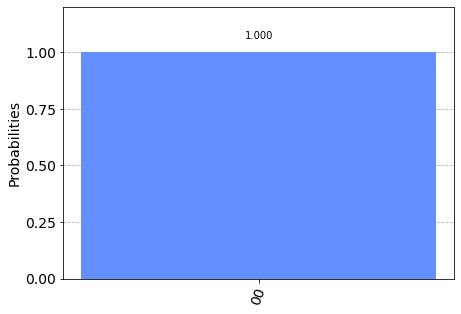

In [12]:
plot_histogram(counts[0])

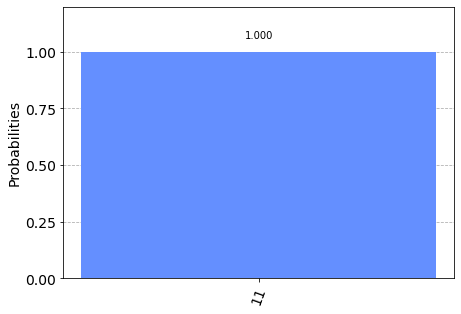

In [13]:
plot_histogram(counts[1])